In [1]:
import os
import glob
import numpy as np
import pandas as pd
import requests
from datetime import datetime, date, time, timedelta
from typing import Tuple, Union, Optional
from itertools import chain


# for ML models:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, save, output_file
from bokeh.palettes import Category20
from bokeh.models.widgets import PreText
from bokeh.models import BooleanFilter, ColumnDataSource, IndexFilter, BoxAnnotation, Band, Span, Select, LinearAxis, DataRange1d, Range1d
from bokeh.models.formatters import PrintfTickFormatter, NumeralTickFormatter
from bokeh.layouts import column
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data
import yfinance as yf
import quantstats as qs
import ta


In [2]:
WIDTH_PLOT = 1500

RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

# TOOLS = 'pan,wheel_zoom,reset'
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

The data was extracted from yfinance, we chose IVV ticker for S&P 500 ETF, since its investable.\
the yfinance data inclused the Adjusted return column: a calculation adjustment made to a stock’s closing price.\
The original closing price does not exemplify the most accurate valuation of the stock or security since it will not account for any actions that could’ve caused the price to shift. Therefore, an adjusted closing price will include any adjustments that need to be made to the price\
The adjustments made are to compensate for anything that could’ve affected the stock’s value, such as a corporate action. The corporate actions can include dividends or stock splits. The adjustment made to the closing price will display the true price of the stock or security because certain outside factors could’ve altered the true price.\
LOG-RETURN: https://medium.datadriveninvestor.com/why-we-use-log-returns-for-stock-returns-820cec4510ba \
log returns are the preferred way to model stock returns, as proven in this article

The use of the 'Adj Close' column instead of the 'Close' column to plot the chart above is due to the adjustment of historical prices for dividends and stock splits. The 'Adj Close' value represents the closing price adjusted for these factors, which allows for a more accurate representation of the stock's true price over time.


In [3]:
# Ticker symbol for iShares Core S&P 500 ETF (IVV)
ticker_symbol = "IVV"

# Extracting data
ivv_data = yf.download(ticker_symbol, start="2002-01-01", end="2024-01-01", interval="1d")
# https://corporatefinanceinstitute.com/resources/equities/adjusted-closing-price/
ivv_data['Return'] = np.log(ivv_data['Adj Close']/ivv_data['Adj Close'].shift(1)).dropna()
# Displaying the first few rows of the data
print(ivv_data.head())
ivv_data.info()

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close  Adj Close  Volume  \
Date                                                                            
2002-01-02  115.000000  115.570000  113.860001  115.449997  75.894180  987900   
2002-01-03  115.449997  116.779999  115.449997  116.779999  76.768517  359500   
2002-01-04  117.120003  117.860001  116.550003  117.599998  77.307533  154100   
2002-01-07  117.599998  117.959999  116.599998  116.709999  76.722496  220900   
2002-01-08  116.739998  117.019997  116.019997  116.230003  76.406944  124300   

              Return  
Date                  
2002-01-02       NaN  
2002-01-03  0.011455  
2002-01-04  0.006997  
2002-01-07 -0.007596  
2002-01-08 -0.004121  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5537 entries, 2002-01-02 to 2023-12-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  ----- 

In [4]:
ivv_data.describe(include='all')

,Open,High,Low,Close,Adj Close,Volume,Return
count,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5.537000e+03,5536.000000
mean,204.134851,205.267334,202.882379,204.157000,176.793921,3.473057e+06,0.000332
std,108.970042,109.540483,108.366692,108.996600,115.614783,2.728486e+06,0.012113
min,68.160004,70.129997,67.220001,68.190002,51.105190,4.490000e+04,-0.123007
25%,119.559998,120.150002,118.870003,119.599998,86.645638,1.717800e+06,-0.004379
50%,153.220001,153.669998,152.330002,152.970001,119.062088,3.137300e+06,0.000724
75%,272.839996,274.760010,270.980011,272.730011,246.639450,4.590100e+06,0.005881
max,481.369995,482.070007,478.519989,479.839996,477.479950,3.874850e+07,0.105255


### Returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 21Y-TREASURY: No timezone found, symbol may be delisted

sp500 Daily Returns Plot:



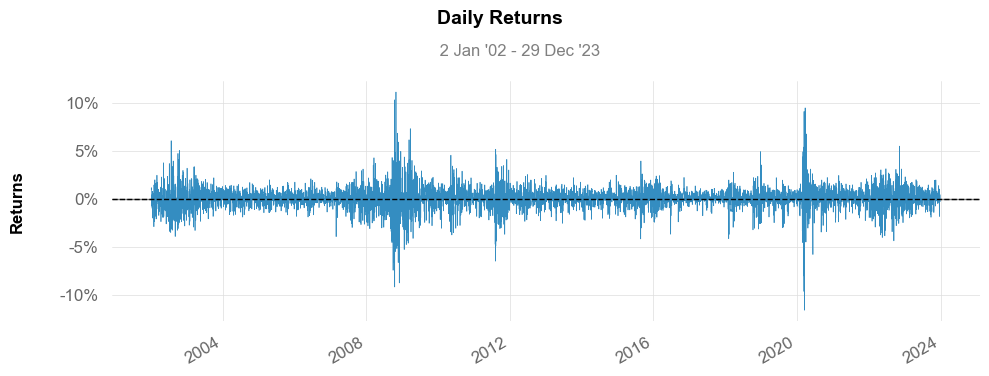




sp500 Cumulative Returns Plot



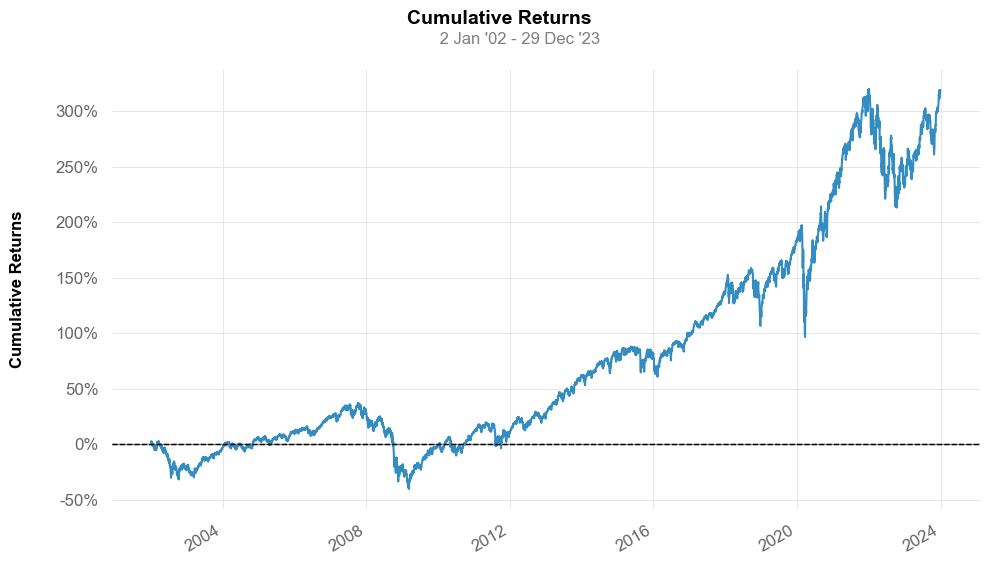




sp500 Inc. Daily Returns Histogram


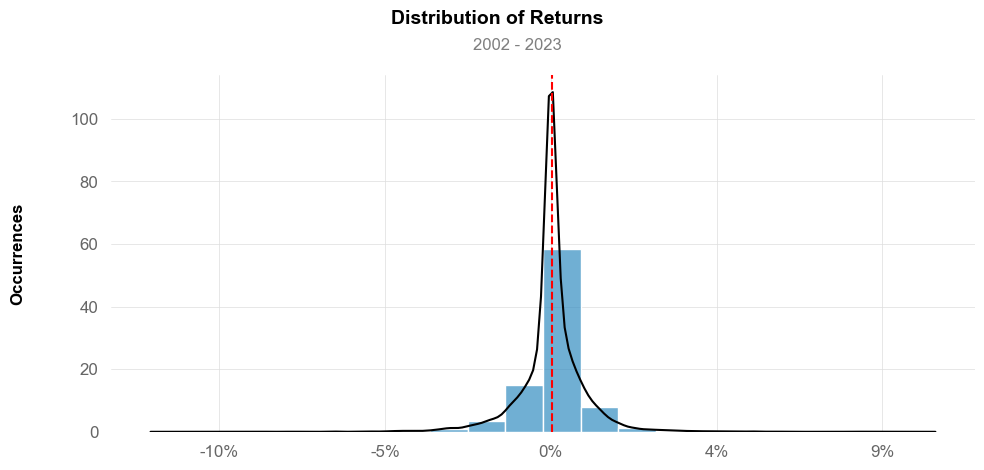

In [5]:
sp = qs.utils.download_returns("IVV")
sp500 = sp.loc['2002-01-01':'2024-01-01']
sp500.index = sp500.index.tz_localize('UTC')
benchmark = qs.utils.download_returns("21Y-Treasury")

print('\nsp500 Daily Returns Plot:\n')
qs.plots.daily_returns(sp500, benchmark=benchmark)

# Plotting Cumulative Returns for each stock
print('\n')
print('\nsp500 Cumulative Returns Plot\n')
qs.plots.returns(sp500)

# Plotting histograms for daily returns 
print('\n')
print('\nsp500 Inc. Daily Returns Histogram')
qs.plots.histogram(sp500, resample = 'D')

### Skewness - Kurtosis

In [6]:
# Using quantstats to measure kurtosis
print("SP500 kurtosis: ", qs.stats.kurtosis(sp500).round(2))
# Measuring skewness with quantstats
print('\n')
print("SP500 skewness: ", qs.stats.skew(sp500).round(2))
# Calculating Standard Deviations
print('\n')
print("SP500 Standard Deviation from 2002 to 2023: ", sp500.std().round(3))
# Calculating Sharpe ratio
print('\n')
print("Sharpe Ratio for SP500: ", qs.stats.sharpe(sp500).round(2))

SP500 kurtosis:  10.52


SP500 skewness:  -0.18


SP500 Standard Deviation from 2002 to 2023:  0.012


Sharpe Ratio for SP500:  0.43


The stocks are subject to high levels of volatility and risk, with considerate price fluctuations that deviate significantly from their average returns.
a value between -0.5 and 0.5 indicates a slight level of skewness, forn std it shows that sp500 is safer investment options, exhibiting more stable price fluctuations in the market.

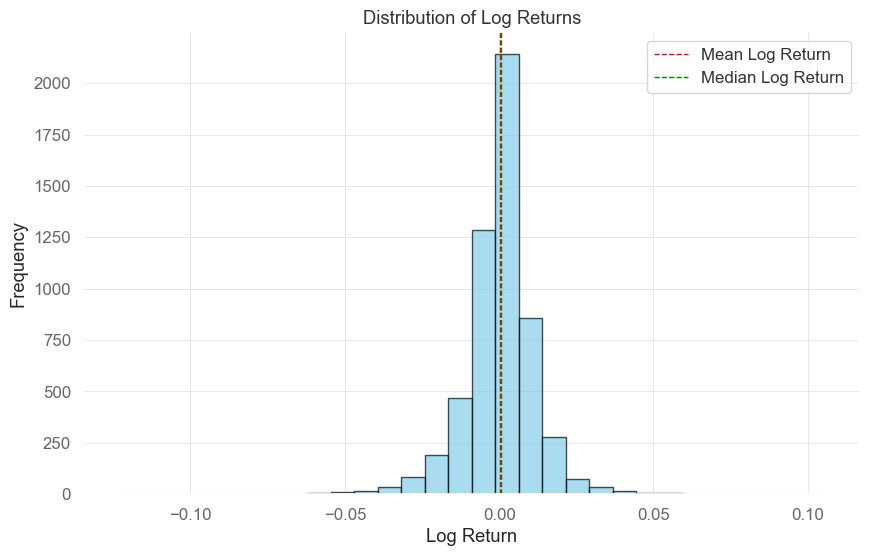

In [7]:
# chach for imbalance in the return: if Skewness is high?
log_returns = ivv_data['Return']


# Plot histogram of log discrete returns
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line indicating the mean of log discrete returns
mean_log_return = log_returns.mean()
plt.axvline(mean_log_return, color='red', linestyle='dashed', linewidth=1, label='Mean Log Return')
median_log_return = log_returns.median()
plt.axvline(median_log_return, color='green', linestyle='dashed', linewidth=1, label='Median Log Return')
# Show legend
plt.legend()

plt.show()

### Price and Volume

In [8]:
# Plotting candlestick chart without indicators
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights = [0.7, 0.3])
fig.add_trace(go.Candlestick(x=ivv_data.index,
                             open=ivv_data['Open'],
                             high=ivv_data['High'],
                             low=ivv_data['Low'],
                             close=ivv_data['Adj Close'],
                             name='SP500'),
              row=1, col=1)


# Plotting volume chart on the second row 
fig.add_trace(go.Bar(x=ivv_data.index,
                     y=ivv_data['Volume'],
                     name='Volume',
                     marker=dict(color='orange', opacity=1.0)),
              row=2, col=1)

# Plotting annotation
fig.add_annotation(text='SP500',
                    font=dict(color='black', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)

# Configuring layout
fig.update_layout(title='SP500 Candlestick Chart From Jan 1st, 2002 to December 30th, 2023',
                  yaxis=dict(title='Price (USD)'),
                  height=1000)

# Configuring axes and subplots
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)
fig.update_yaxes(title_text='Price (USD)', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)

fig.show()


### Anomalies Detection

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-06-14  424.920013  425.779999  423.540009  425.760010  408.278748   
2021-06-24  426.690002  427.380005  426.440002  426.869995  409.343170   
2021-06-25  427.760010  428.910004  427.399994  428.440002  410.848724   
2021-06-28  429.040009  429.489990  427.720001  429.350006  411.721466   
2021-06-29  429.760010  430.380005  428.980011  429.540009  411.903564   

             Volume    Return   Z-score  
Date                                     
2021-06-14  2158800  0.002399  2.002389  
2021-06-24  4817200  0.005779  2.011596  
2021-06-25  4171500  0.003671  2.024619  
2021-06-28  4015300  0.002122  2.032169  
2021-06-29  3324400  0.000442  2.033744  


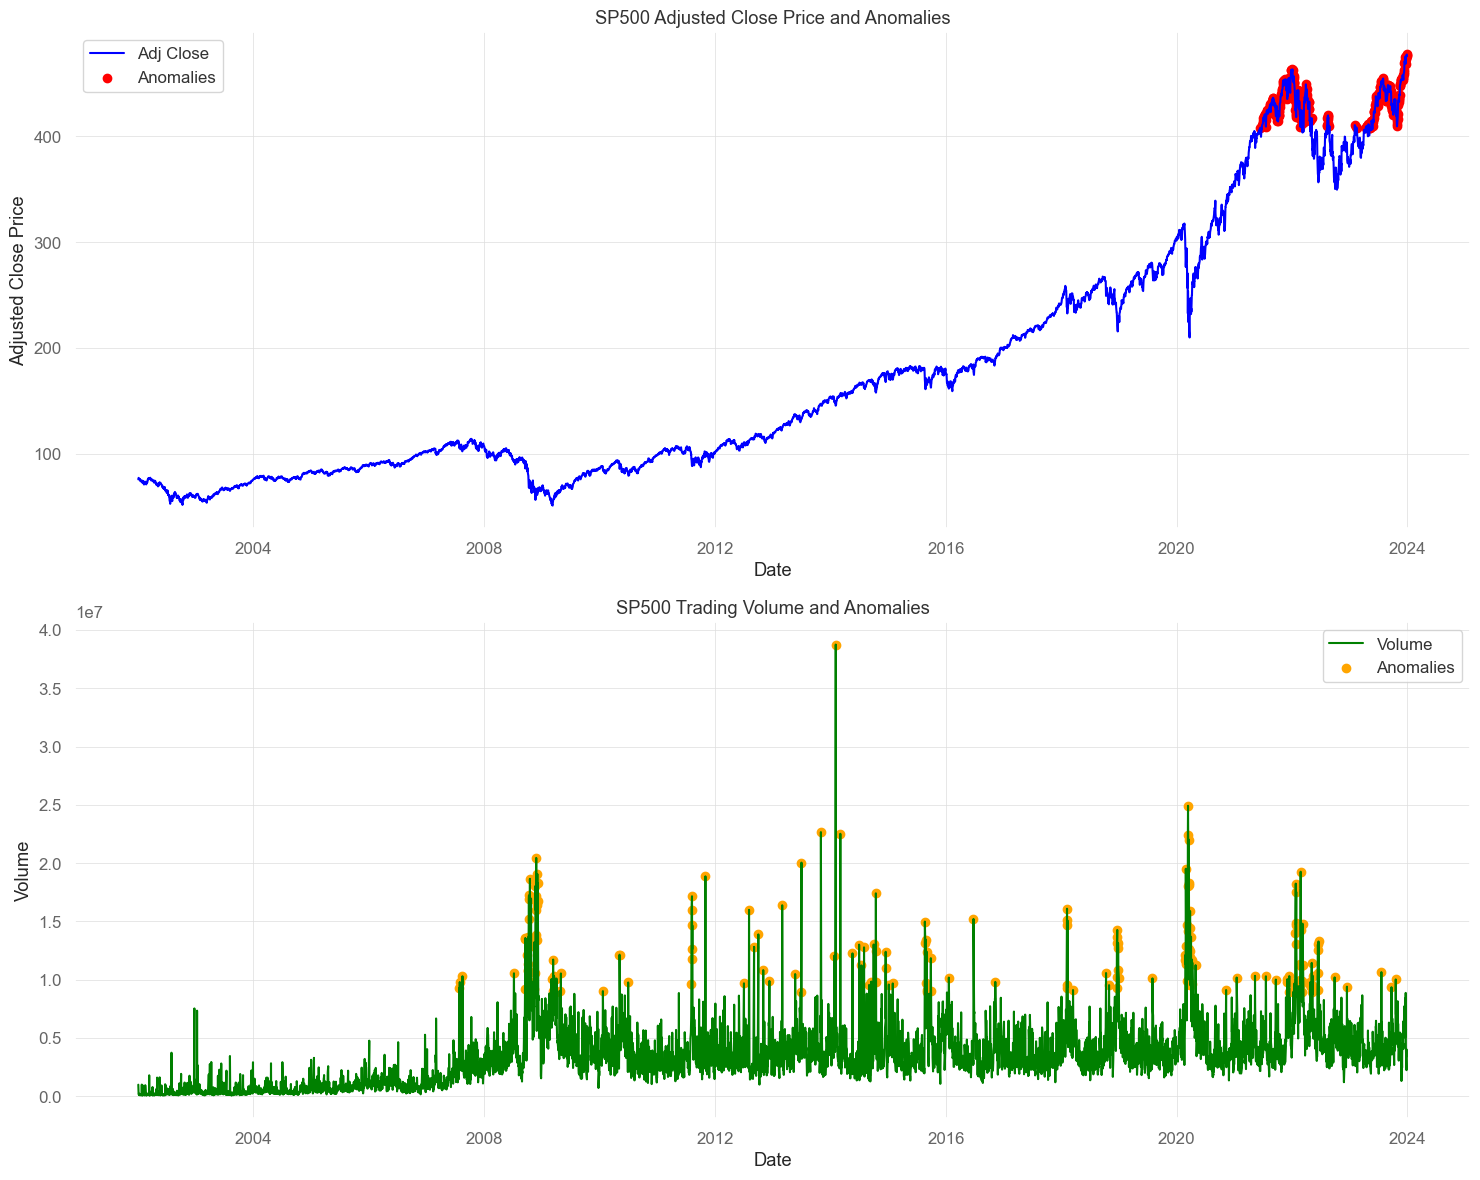

In [9]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

# for ticker in stock_data['Ticker'].unique():
#     data_ticker = stock_data[stock_data['Ticker'] == ticker]

#     adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
#     volume_anomalies = detect_anomalies(data_ticker, 'Volume')

#     # use concat instead of append
#     anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
#     anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])
adj_close_anomalies = detect_anomalies(ivv_data, 'Adj Close')
volume_anomalies = detect_anomalies(ivv_data, 'Volume')

# use concat instead of append
anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

def plot_anomalies(data_ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    # data_ticker = stock_data[stock_data['Ticker'] == ticker]
    # adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    # volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(anomalies_adj_close.index, anomalies_adj_close['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'SP500 Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(anomalies_volume.index, anomalies_volume['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'SP500 Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
# for ticker in stock_data['Ticker'].unique():
plot_anomalies(ivv_data, anomalies_adj_close, anomalies_volume)

### Technical analysis: 
is a very popular method used for many traders and investors to evaluate stocks and other assets based on historical price and volume data. It is an approach used to identify trends, or lack of trends, and help traders and investors to make decisions based on what they believe the future price movements will be. The underlying assumption of technical analysis is that past patterns and price movements tend to repeat themselves, so those can be used to predict future movements. Therefore, technical analysts examine charts and look for opportunities in patterns and indicators.
Despite its popularity among traders, the use of technical analysis may be controversial. Some critics argue that technical analysis relies too heavily on subjective interpretations of chart patterns and that it lacks a clear theoretical foundation. They also argue that technical analysis is prone to false signals and that traders who rely on technical analysis may miss out on important fundamental factors that can influence the price of stocks.
It can be said that technical analysis tend to be more appropriate for short-term trading, whereas fundamental analysis may be better suited for long-term investing. Fundamental analysis provides investors with a more comprehensive understanding of a company's financial health and long-term growth prospects.
It can also be said that, while humans tend to operate better with fundamental analysis, as it requires a deep understanding of the underlying factors that drive a company's value, computers may operate better with technical analysis, as it relies heavily on quantitative data that can be analyzed quickly and efficiently. An evidence to that is the fact that the use of automated trading bots that trade based on technical analysis has become increasingly popular in recent years. These bots use algorithms to identify patterns and trends in price data and make trades based on technical signals.

#### The accumulation/distribution indicator (A/D): 
is a cumulative indicator that uses volume and price to assess whether a stock is being accumulated or distributed. The A/D measure seeks to identify divergences between the stock price and the volume flow. This provides insight into how strong a trend is. If the price is rising but the indicator is falling, then it suggests that buying or accumulation volume may not be enough to support the price rise and a price decline could be forthcoming.

In [10]:
def calculate_accumulation_distribution_indicator(close_prices: np.ndarray, high_prices: np.ndarray, low_prices: np.ndarray, volume: np.ndarray) -> np.ndarray:
    """
    Calculate Accumulation/Distribution Indicator (ADL or ADO) for a given security.

    Parameters:
    - high: High prices series (list, numpy array, or pandas Series)
    - low: Low prices series (list, numpy array, or pandas Series)
    - close: Close prices series (list, numpy array, or pandas Series)
    - volume: Volume series (list, numpy array, or pandas Series)

    Returns:
    - adl: Accumulation/Distribution Indicator series (pandas Series)
    """

    # Calculate money flow multiplier
    money_flow_multiplier = ((close_prices - low_prices) - (high_prices - close_prices)) / (high_prices - low_prices)

    # Calculate money flow volume
    money_flow_volume = money_flow_multiplier * volume

    # Calculate Accumulation/Distribution Line
    adl = money_flow_volume.cumsum()

    return adl

#### Volatility Indicators:/

Volatility can be measured in a number of ways, including VIX, ATR, and Bollinger Bands to determine optimal exit or entry points for trades. While high volatility is often a deterrent for a risky trade, increased fear during extreme market moves and larger price swings can also create buying opportunities and provide an exceptional trading ground for experienced investors./

Daily variation: a measure of volatility, or how much a stock's value changes.It is the difference between its highest and lowest values on a given trading day. A stock with a very large daily price variation is very volatile and may be expected to change its value quickly over time. When daily price variations are small, it indicates more consensus within the market about the value of the stock. Stable daily price variations over time show that a stock is unlikely to shoot up or plummet in value on any given day./

Average True Range (ATR) is the average of true ranges over the specified period. ATR measures volatility, taking into account any gaps in the price movement. Typically, the ATR calculation is based on 14 periods, which can be intraday, daily, weekly, or monthly. ATR is very useful for stops or entry triggers, signaling changes in volatility. Whereas fixed dollar- point or percentage stops will not allow for volatility, the ATR stop will adapt to sharp price moves or consolidation areas, which can trigger an abnormal price movement in either direction./

The Bollinger Bands consist of three lines on a chart: a simple moving average (SMA) in the middle,typically a 20-day moving average, and two bands that are set at a distance of two standard deviations away from the SMA. When the market is volatile, the bands widen, and when the market is less volatile, the bands contract. The distance between the bands can therefore be used as an indicator of volatility.It is designed to give investors a higher probability of identifying when an asset is oversold or overbought. Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band. Many traders believe the closer the prices move to the upper band, the more overbought the market, and the closer the prices move to the lower band, the more oversold the market./

Overbought --> Sell
Oversold --> Buy

In [11]:
# Volatility Indicators

# Average True Range (ATR)
def calculate_atr(open_prices: np.ndarray, high_prices: np.ndarray, low_prices: np.ndarray, window: int) -> np.ndarray:
    daily_variation = (high_prices - low_prices) / open_prices
    return daily_variation.rolling(window=window).mean()

# Bollinger Band
def calculate_bollinger_bands(close_prices: np.ndarray, window: int, num_std=2):
    """
    Calculate the Bollinger Bands for a given set of closing prices.

    Parameters:
    - close_prices: List or array of closing prices
    - window: Size of the moving average window (default is 20)
    - num_std: Number of standard deviations for the bands (default is 2)

    Returns:
    - bollinger_upper: List of upper Bollinger Band values
    - bollinger_lower: List of lower Bollinger Band values
    """
    close_series = pd.Series(close_prices)
    sma = close_series.rolling(window=window).mean()
    rolling_std = close_series.rolling(window=window).std()

    bollinger_upper = sma + (rolling_std * num_std)
    bollinger_lower = sma - (rolling_std * num_std)

    return round(bollinger_upper,2), round(sma, 2), round(bollinger_lower,2)

# Bollinger Band Width
def calculate_bollinger_width(bollinger_upper: np.ndarray, sma: np.ndarray, bollinger_lower: np.ndarray) -> np.ndarray:
    return (bollinger_upper - bollinger_lower) / sma

In [12]:
# Main chart for stock prices with candlestick and Bolinger bands
def plot_stock_price(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=400,
               title="Stock price + Bollinger Bands (2 std)",
               tools=TOOLS, toolbar_location='above')

    inc_data = stock[stock['Close'] > stock['Open']]
    dec_data = stock[stock['Open'] > stock['Close']]

    width = 35000000

    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=RED, source=inc_data)
    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=GREEN, source=dec_data)

    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=inc_data)
    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
           source=dec_data)

    # Plot Simple Moving Average
    p.line(x='Date', y='sma', line_width=2, color=BLUE, line_alpha=0.7,source=stock)
    
    # Creating vertices for the cloud-like shape between Bollinger Bands
    cloud_x = list(stock['Date']) + list(stock['Date'][::-1])
    cloud_y = list(stock['bolling_upper']) + list(stock['bolling_lower'][::-1])

    cloud_source = ColumnDataSource(data=dict(x=cloud_x, y=cloud_y))

    # Creating the patch for the cloud-like shape
    p.patch('x', 'y', color=BLUE_LIGHT, line_color='black', alpha=0.3, source=cloud_source)
    
    # Sort by distances
    stock_sorted_upper = stock.sort_values(by='distance_upper', ascending=True)
    stock_sorted_lower = stock.sort_values(by='distance_lower', ascending=True)

    # Add pointers to top 5 overbought and oversold points
    p.triangle(x=stock_sorted_upper.iloc[:5]['Date'], y=stock_sorted_upper.iloc[:5]['Close'], size=10, color='darkorange', legend_label='Top 5 Overbought[best to sell]')
    p.inverted_triangle(x=stock_sorted_lower.iloc[:5]['Date'], y=stock_sorted_lower.iloc[:5]['Close'], size=10, color='darkblue', legend_label='Top 5 Oversold[best to buy]')

    # Set legend position
    p.legend.location = "top_left"

    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p

def plot_bbw(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Bollinger Band Width",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='bbw', line_width=2, color='orange', source=stock)
    
    return p_sub

def plot_atr(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Average True Range (ATR)",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='atr', line_width=2, color='purple', source=stock)
    
    return p_sub

In [13]:
# Visualize Volatility:
vis1_df = ivv_data.reset_index()
vis1_df['bolling_upper'], vis1_df['sma'], vis1_df['bolling_lower'] = calculate_bollinger_bands(vis1_df['Close'], window=15)
vis1_df['distance_upper'] = vis1_df['bolling_upper'] - vis1_df['Close']
vis1_df['distance_lower'] = vis1_df['Close'] - vis1_df['bolling_lower']
vis1_df['bbw'] = calculate_bollinger_width(vis1_df['bolling_upper'], vis1_df['sma'], vis1_df['bolling_lower'])
vis1_df['atr'] = calculate_atr(vis1_df['Open'], vis1_df['High'], vis1_df['Low'], window=14)

p = plot_stock_price(vis1_df.dropna())
p_sub = plot_bbw(vis1_df.dropna())
p_sub2 = plot_atr(vis1_df.dropna())

# Combine the plots
# output_notebook()
plot_combined = column(p, p_sub, p_sub2)
show(plot_combined)



#### Moving Averages:
There are two types of moving averages: simple moving averages (SMA) and exponential moving averages (EMA). SMA calculates the average price of the asset over the specified period of time and gives equal weight to each data point.So, for instance, a 20-day SMA would take the sum of the closing prices over the past 20 days and divide by 20 to get the average price.
EMA, on the other hand, gives more weight to recent price action. The formula for calculating EMA involves using a multiplier that gives more weight to the most recent price data.
When a shorter-term EMA line crosses above a longer-term EMA line, it may be considered a buy signal, while when a shorter-term EMA line crosses below a longer-term EMA line, it may be considered a sell signal.\

Moving Average Convergence Divergence(MACD): help identify price trends, measure trend momentum, and identify market entry points for buying or selling. Buy when the MACD line crosses above the signal line and sell when the MACD line crosses below the signal line. 

Directional Moving Index: The Directional Movement Index (DMI) assists in determining if a security is trending and attempts to measure the strength of the trend. The DMI disregards the direction of the security. It only attempts to determine if there is a trend and that trends strength.\
A buy signal is given when DMI+ crosses above DMI-. A sell signal is given when DMI- crosses above DMI+. The ADX and ADXR lines are then used to measure the strength of these signals.

In [14]:
# Exponential Moving Average: to reduce lag in responsiveness to price movements.
# calculate for 12, 15, 26
def calculate_ema(close_prices: np.ndarray, window: int) -> np.ndarray:
    return close_prices.ewm(span=window, adjust=False).mean()

 # Moving Average Convergence Divergence
def calculate_macd(close_prices:np.ndarray, 
                   short_window: int, 
                   long_window: int, 
                   signal_window: int):
    # Calculate short-term (fast) EMA
    short_ema = close_prices.ewm(span=short_window, min_periods=1, adjust=False).mean()

    # Calculate long-term (slow) EMA
    long_ema = close_prices.ewm(span=long_window, min_periods=1, adjust=False).mean()

    # Calculate MACD line
    macd = short_ema - long_ema

    # Calculate MACD signal line
    macd_signal = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()

    # Calculate MACD histogram
    macd_histogram = macd - macd_signal

    return macd_histogram, macd, macd_signal
#macd_12_26 =  ema_12 - ema_26

def calculate_dmi(high_prices:np.ndarray, low_prices:np.ndarray):
    high_shifted = high_prices.shift(1)
    low_shifted = low_prices.shift(1)
    dm_plus = high_prices - high_shifted
    dm_minus = low_shifted - low_prices
    dm_plus[dm_plus < 0] = 0
    dm_minus[dm_minus < 0] = 0
    tr =  (high_prices - low_prices) 
    atr = tr.rolling(window=14).mean()
    di_plus = (dm_plus / atr).rolling(window=14).mean() * 100
    di_minus = (dm_minus / atr).rolling(window=14).mean() * 100
    adx = np.abs(di_plus - di_minus) / (di_plus + di_minus) * 100 # Average Directional Movement Index
    return di_plus, di_minus, adx


In [15]:
def plot_stock_averages(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=400,
               title="Stock price",
               tools=TOOLS, toolbar_location='above')

    inc_data = stock[stock['Close'] > stock['Open']]
    dec_data = stock[stock['Open'] > stock['Close']]

    width = 35000000

    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=RED, source=inc_data)
    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=GREEN, source=dec_data)

    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=inc_data)
    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
           source=dec_data)

    # Sort by distances
    stock_sorted_upper = stock.sort_values(by='long_short', ascending=True)
    stock_sorted_lower = stock.sort_values(by='short_long', ascending=True)

    # Add pointers to top 5 overbought and oversold points
    p.triangle(x=stock_sorted_upper.iloc[:5]['Date'], y=stock_sorted_upper.iloc[:5]['Close'], size=10, color='darkorange', legend_label='Top 5 periods to sell')
    p.inverted_triangle(x=stock_sorted_lower.iloc[:5]['Date'], y=stock_sorted_lower.iloc[:5]['Close'], size=10, color='darkblue', legend_label='Top 5 periods to buy')

    # Add legend
    p.legend.location = "top_left"
    
    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')
    
    return p


def plot_ema(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Exponential Moving Average(EMA)",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='ema_short', legend_label='ema short', line_width=2, color='gold', source=stock)
    p_sub.line(x='Date', y='ema_long', legend_label='ema long',line_width=2, color='green', source=stock)
    p_sub.legend.location = "top_left"
    return p_sub

# MACD (line + histogram)
def plot_macd(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=300, title="MACD (line + histogram)",
               tools=TOOLS, toolbar_location='above')

    up = stock[stock['macd_histogram'] > 0]
    down = stock[stock['macd_histogram']<0]


    p.vbar(x='Date', top='macd_histogram', bottom=0, width=30000000, color=GREEN, source=up, legend_label='MACD Histogram (Positive)')
    p.vbar(x='Date', top=0, bottom='macd_histogram', width=30000000, color=RED, source=down,legend_label='MACD Histogram (Negative)')

    # Adding an extra range for the MACD lines, because using the same axis as the histogram
    # sometimes flattens them too much
    p.extra_y_ranges = {'macd': DataRange1d()}
    p.add_layout(LinearAxis(y_range_name='macd'), 'right')

    p.line(x='Date', y='macd', line_width=2, color=BLUE, source=stock, legend_label='MACD', muted_color=BLUE,
           muted_alpha=0, y_range_name='macd')
    p.line(x='Date', y='macd_signal', line_width=2, color=BLUE_LIGHT, source=stock, legend_label='Signal',
           muted_color=BLUE_LIGHT, muted_alpha=0, y_range_name='macd')

    p.legend.location = "bottom_left"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"

    p.yaxis.ticker = []
    p.yaxis.axis_line_alpha = 0

    return p

def plot_dmi(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Directional Moving Index(DMI)",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='di_plus', legend_label='DI+',line_width=2, color='purple', source=stock)
    p_sub.line(x='Date', y='di_minus',legend_label='DI-', line_width=2, color='orange', source=stock)
    p_sub.line(x='Date', y='adx', legend_label='Average Directional Movement Index', line_width=1,alpha=0.3 ,color='blue', source=stock)
    
    p_sub.legend.location = "top_left"

    return p_sub

In [16]:
# Visualize averages:
vis1_df['ema_short'] = calculate_ema(vis1_df['Close'], window=12)
vis1_df['ema_long'] = calculate_ema(vis1_df['Close'], window=26)
vis1_df['short_long'] = vis1_df['ema_short'] - vis1_df['ema_long']
vis1_df['long_short'] = vis1_df['ema_long'] -  vis1_df['ema_short']
vis1_df['macd_histogram'], vis1_df['macd'], vis1_df['macd_signal'] = calculate_macd(vis1_df['Close'], short_window=12, long_window=26, signal_window=14)
vis1_df['macd_above'] = vis1_df['macd'] - vis1_df['macd_signal']
vis1_df['macd_under'] = vis1_df['macd_signal'] - vis1_df['macd']
vis1_df['di_plus'], vis1_df['di_minus'], vis1_df['adx'] = calculate_dmi(vis1_df['High'], vis1_df['Low'])

p2 =  plot_stock_averages(vis1_df.dropna())
p2_sub = plot_ema(vis1_df.dropna())
p2_sub2 = plot_macd(vis1_df.dropna())
p2_sub3 = plot_dmi(vis1_df.dropna())

plot2_combined = column(p2, p2_sub, p2_sub2, p2_sub3)

show(plot2_combined)

#### Oscillators:

Relative Strength Index (RSI): is a momentum indicator that measures recent price changes as it moves between 0 and 100. The RSI provides short-term buy and sell signals and is used to track the overbought and oversold levels of an asset.
Low RSI levels, below 30, generate buy signals and indicate an oversold or undervalued condition. High RSI levels, above 70, generate sell signals and suggest that a security is overbought or overvalued.

Williams %R: A trader might sell when the Williams %R indicator is above the overbought line (80) and then falls below the 80 line.
Read more at: https://commodity.com/technical-analysis/williams-r/

Fast stochastic indicator (%K) : is a momentum technical indicator that aims to measure the trend in prices and identify trend reversals. Typically, a stock is considered overbought if the %K is above 80 and oversold if %K is below 20. Buy signals are given when %K moves up through the %D line(%K below 20) . Sell signals are given when %K moves down through the %D line(%K above 80), It indicates a weakness in the uptrend and that the price may begin to fall. %D divergence is the 3-day SMA of the %K. It is a smoothed version of the %K. It is computed because %K is a volatile indicator and can lead to spurious signals. A smoothed version (%D) moves much slower than the %K; hence the signals generated indicate a stronger trend. When the stochastic oscillator falls below 20, the trader should look for two further conditions. First, the trader should check if the %K has fallen below %D, then see if there is a divergence in the movement of %K and the stock price. If the stock price has fallen further, but the %K rises, then it is a reversal in the trend. According to the stochastic oscillator analysis, it is a buy signal, and the trader should place a buy order. The stock is sold when the oscillator crosses 80, and a sell signal is generated. When the stochastic indicator rises above 80, it is the precondition to search for the bear divergence. A bear divergence occurs when the %K is above %D. Further, the stock price makes a high while the oscillator (%K) falls. It indicates a weakness in the uptrend and that the price may begin to fall. According to stochastic oscillator analysis, it is a sell signal, and the trader should place a sell order. The stock is repurchased when the next buy signal is generated. The fast stochastic indicator is much more volatile than the slow indicator. It generates many more buy and sell signals than the slow indicator( we will use fast %K, and fast %D)
Read more at: https://corporatefinanceinstitute.com/resources/career-map/sell-side/capital-markets/fast-stochastic-indicator/#:~:text=A%20bear%20divergence%20occurs%20when,should%20place%20a%20sell%20order.

In [17]:
# Oscillators

# Stochastic Oscillator (STOCH) 
def calculate_stoch(close_prices: np.ndarray, 
                    low_prices: np.ndarray, 
                    high_prices: np.ndarray, 
                    n_fast_k=14, 
                    n_fast_d=3,
                    n_slow_d=3):
    # Calculate %K
    L14 = low_prices.rolling(window=n_fast_k).min()
    H14 = high_prices.rolling(window=n_fast_k).max()
    K = 100 * (close_prices - L14) / (H14 - L14) 
    # Calculate %D [fast, slow]
    D_Fast = K.rolling(window=n_fast_d).mean()  
    D_Slow = D_Fast.rolling(window=n_slow_d).mean()
    return K, D_Fast, D_Slow

# Relative Strength Index
# calculate for 14 days
def calculate_rsi(close_prices: np.ndarray, window: int) -> np.ndarray:
    delta = close_prices.diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window-1 , min_periods=window).mean()
    ema_down = down.ewm(com=window-1 , min_periods=window).mean()
    return 100 * ema_up/(ema_down + ema_up)

# Williams %R: between 0 and -100 
# calculate for 14 days 
def calculate_williams(close_prices: np.ndarray, 
                       low_prices: np.ndarray, 
                       high_prices: np.ndarray, 
                       window: int) -> np.ndarray:
    highest_high = high_prices.rolling(window).max()
    lowest_low = low_prices.rolling(window).min()
    williams = ((highest_high - close_prices) / (highest_high - lowest_low)) * 100
    
    return williams

In [18]:
def plot_stock_osci(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=400,
               title="Stock price",
               tools=TOOLS, toolbar_location='above')

    inc_data = stock[stock['Close'] > stock['Open']]
    dec_data = stock[stock['Open'] > stock['Close']]

    width = 35000000

    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=RED, source=inc_data)
    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=GREEN, source=dec_data)

    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=inc_data)
    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
           source=dec_data)

    # Sort by distances
    stock_sorted_under = stock.sort_values(by='macd_under', ascending=True)
    stock_sorted_above = stock.sort_values(by='macd_above', ascending=True)

    # Add pointers to top 5 overbought and oversold points
    p.triangle(x=stock_sorted_under.iloc[:5]['Date'], y=stock_sorted_under.iloc[:5]['Close'], size=10, color='darkorange', legend_label='Top 5 periods to sell')
    p.inverted_triangle(x=stock_sorted_above.iloc[:5]['Date'], y=stock_sorted_above.iloc[:5]['Close'], size=10, color='darkblue', legend_label='Top 5 periods to buy')

    # Add legend
    p.legend.location = "top_left"
    
    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')
    
    return p




# RSI
def plot_rsi(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200, title="RSI 14 days\nPink --> Buy | Green --> Sell",
               tools=TOOLS, toolbar_location='above')

    p.line(x='Date', y='rsi', line_width=2, color=BLUE, source=stock)

    low_box = BoxAnnotation(top=20, fill_alpha=0.1, fill_color=RED)
    p.add_layout(low_box)
    high_box = BoxAnnotation(bottom=80, fill_alpha=0.1, fill_color=GREEN)
    p.add_layout(high_box)

    # Horizontal line
    hline = Span(location=50, dimension='width', line_color='black', line_width=0.5)
    p.renderers.extend([hline])

    p.y_range = Range1d(0, 100)
    p.yaxis.ticker = [20, 50, 800]
    p.yaxis.formatter = PrintfTickFormatter(format="%f%%")
    p.grid.grid_line_alpha = 0.2

    return p

# RSI
def plot_williams(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200, title="Williams %R 14 days\nPink --> Buy | Green --> Sell",
               tools=TOOLS, toolbar_location='above')

    p.line(x='Date', y='williams', line_width=2, color=BLUE, source=stock)

    low_box = BoxAnnotation(top=20, fill_alpha=0.1, fill_color=RED)
    p.add_layout(low_box)
    high_box = BoxAnnotation(bottom=80, fill_alpha=0.1, fill_color=GREEN)
    p.add_layout(high_box)

    # Horizontal line
    hline = Span(location=50, dimension='width', line_color='black', line_width=0.5)
    p.renderers.extend([hline])

    p.y_range = Range1d(0, 100)
    p.yaxis.ticker = [20, 50, 800]
    p.yaxis.formatter = PrintfTickFormatter(format="%f%%")
    p.grid.grid_line_alpha = 0.2

    return p

#  %K, %D
def plot_k_d(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200, title="%K - %D 14 days\nPink --> Buy | Green --> Sell",
               tools=TOOLS, toolbar_location='above')

    p.line(x='Date', y='k', line_width=2, color=BLUE, source=stock)
    p.line(x='Date', y='d_fast', line_width=2, color=ORANGE,alpha=0.6, source=stock)


    low_box = BoxAnnotation(top=20, fill_alpha=0.1, fill_color=RED)
    p.add_layout(low_box)
    high_box = BoxAnnotation(bottom=80, fill_alpha=0.1, fill_color=GREEN)
    p.add_layout(high_box)

    # Horizontal line
    hline = Span(location=50, dimension='width', line_color='black', line_width=0.5)
    p.renderers.extend([hline])

    p.y_range = Range1d(0, 100)
    p.yaxis.ticker = [20, 50, 800]
    p.yaxis.formatter = PrintfTickFormatter(format="%f%%")
    p.grid.grid_line_alpha = 0.3

    return p


In [19]:
# Visualize averages:
vis1_df['rsi']= calculate_rsi(vis1_df['Close'], window=14)
vis1_df['k'], vis1_df['d_fast'], _ = calculate_stoch(vis1_df['Close'], vis1_df['Low'], vis1_df['High'])
vis1_df['williams']= calculate_williams(vis1_df['Close'],vis1_df['Low'], vis1_df['High'], window=14)

p3 = plot_stock_osci(vis1_df.dropna())
p3_sub = plot_williams(vis1_df.dropna())
p3_sub2 = plot_rsi(vis1_df.dropna())
p3_sub3 = plot_k_d(vis1_df.dropna())

plot3_combined = column(p3, p3_sub, p3_sub2, p3_sub3)

show(plot3_combined)

### Target(Dependable) Variable : 
    Trading Signal [Buy, Sell] https://core.ac.uk/download/pdf/239040003.pdf


y pred: is the the predicted return from a regression model

Signal = 
\begin{cases}
1 & \text{if}\quad y_{\text{pred}}(t) \geq q_{0.6} \\
0 & \text{if}\quad q_{0.4} < y_{\text{pred}}(t) < q_{0.6} \\
-1 & \text{if}\quad y_{\text{pred}}(t) \leq q_{0.4}
\end{cases}


In [20]:
def calculate_signals(y_pred: np.ndarray, q_low=0.4, q_high=0.6) -> np.ndarray:
    """
    Calculate trading signals based on predicted values and quantiles.
    signalt = {1  yt ≥ q0.6
               0  q0.4 < yt < q0.6 
               −1 yt ≤ q0.4}
    Parameters:
        y_pred (np.ndarray): Predicted values.

    Returns:
        np.ndarray: Trading signals.
    """
    q_40 = np.quantile(y_pred, q_low)
    q_60 = np.quantile(y_pred, q_high)
    signals = np.zeros_like(y_pred)  # Initialize signals vector with zeros

    # Calculate signals based on quantiles
    signals[y_pred >= q_60] = 1  # Buy signal
    signals[(y_pred > q_40) & (y_pred < q_60)] = 0  # Neutral signal
    signals[y_pred <= q_40] = -1  # Sell signal

    return signals

#### Indicators Dataframe

In [21]:
# create df of indicators:
df = pd.DataFrame(index=ivv_data.index)
df['bolling_upper'], df['sma'], df['bolling_lower'] = calculate_bollinger_bands(ivv_data['Adj Close'], window=14)
df['bbw'] = calculate_bollinger_width(df['bolling_upper'], df['sma'], df['bolling_lower'])

df['ema'] = calculate_ema(ivv_data['Adj Close'], window=14)
_, _, df['macd'] = calculate_macd(ivv_data['Adj Close'], short_window=12, long_window=26, signal_window=14)
df['k'], _ , _ = calculate_stoch(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'])
df['rsi'] = calculate_rsi(ivv_data['Adj Close'], window=14)
df['williams_r'] = calculate_williams(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'], window=14)
df['atr'] = calculate_atr(ivv_data['Open'], ivv_data['High'], ivv_data['Low'], window=14)
_, _, df['adx'] = calculate_dmi(ivv_data['High'], ivv_data['Low'])
df['adi'] = calculate_accumulation_distribution_indicator(ivv_data['Adj Close'], ivv_data['High'], ivv_data['Low'],ivv_data['Volume'])

df['return'] = ivv_data['Return']
df.describe()

,bolling_upper,sma,bolling_lower,bbw,ema,macd,k,rsi,williams_r,atr,adx,adi,return
count,5524.000000,5524.000000,5524.000000,5524.000000,5537.000000,5537.000000,5524.000000,5523.000000,5524.000000,5524.000000,5511.000000,5.537000e+03,5536.000000
mean,181.440599,176.561966,171.683342,0.056312,176.329831,0.474996,-374.465134,54.902686,474.465134,0.012349,30.504702,-2.798448e+11,0.000332
std,118.628192,115.197505,111.891473,0.039947,115.150874,2.071731,323.201295,11.436436,323.201295,0.007962,20.808498,2.031525e+11,0.012113
min,57.280000,54.560000,49.120000,0.004888,54.599775,-16.358803,-1805.139365,16.755363,8.165918,0.003122,0.001169,-5.593374e+11,-0.123007
25%,89.157500,86.500000,84.785000,0.031666,86.262737,-0.218449,-562.873976,46.596636,213.582019,0.007585,13.384257,-4.936586e+11,-0.004379
50%,121.450000,118.000000,116.280000,0.046952,117.648807,0.513347,-322.346029,55.982628,422.346029,0.010008,27.331021,-2.687690e+11,0.000724
75%,254.545000,246.480000,238.330000,0.068004,245.940966,1.240287,-113.582019,63.531469,662.873976,0.014553,44.255420,-7.322678e+10,0.005881
max,482.620000,471.870000,461.640000,0.434837,471.228118,7.492601,91.834082,87.092237,1905.139365,0.077751,99.065886,-4.485510e+07,0.105255


#### Correlation between Indicators

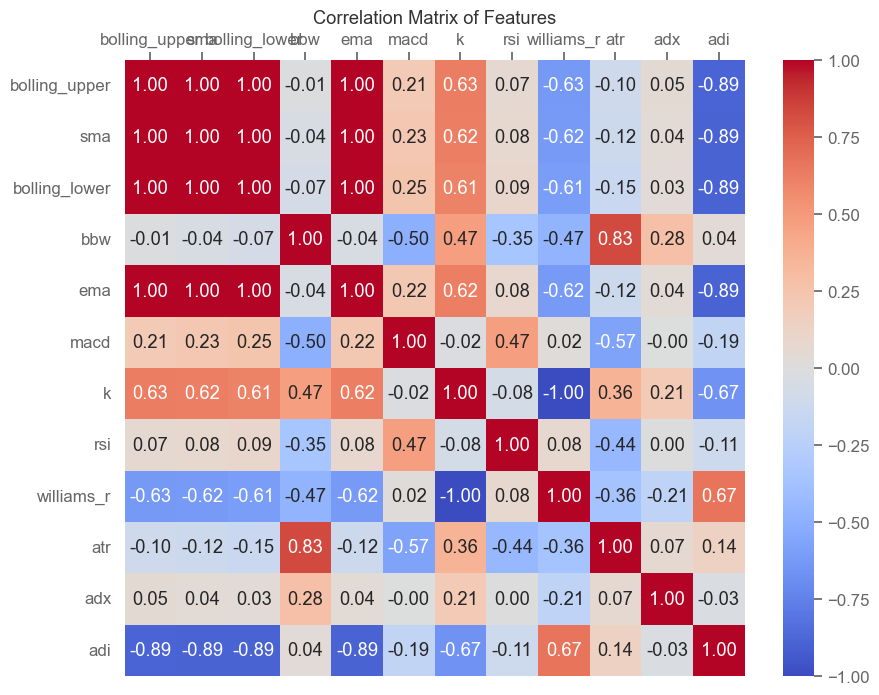

In [22]:
corr_matrix = df.iloc[:,:-1].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
ax.xaxis.tick_top()
plt.show()

### Normalization techniques:

https://itadviser.dev/stock-market-data-normalization-for-time-series/#:~:text=Moving%20average%20normalization%20smoothens%20out,price%20by%20its%20moving%20average.

Data transformation: min-max normalization (rescaled to range from -1 to 1):

$x'_t = \left(\frac{x_t - \min(x)}{\max(x) - \min(x)}\right) \times 2 - 1$


In [23]:
def min_max_scale_df(df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_data = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    return scaled_df

df = df.drop(['bolling_upper', 'bolling_lower', 'sma', 'bbw', 'adi', 'k'], axis=1)#, 'ema', 'sma'

scaled_df = min_max_scale_df(df.iloc[:,:-1].dropna())#.iloc[:,:-1]
scaled_df['return'] = df['return']
scaled_df.describe()

,ema,macd,rsi,williams_r,atr,adx,return
count,5511.000000,5511.000000,5511.000000,5511.000000,5511.000000,5511.000000,5511.000000
mean,-0.413352,0.411802,0.085791,-0.508872,-0.752758,-0.384170,0.000345
std,0.553069,0.174088,0.324616,0.340983,0.213610,0.420099,0.012118
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.123007
25%,-0.847032,0.353838,-0.149039,-0.784134,-0.880519,-0.729811,-0.004301
50%,-0.687091,0.415294,0.116381,-0.564660,-0.815606,-0.448242,0.000731
75%,-0.079612,0.475997,0.330567,-0.311341,-0.693755,-0.106559,0.005881
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.105255


### WFO : walk- forward optimization

|X||V|O|O|O|\
|O|X||V|O|O|\
|O|O|X||V|O|\
|O|O|O|X||V|

X = train

V = validation  

||=indicates a gap (parameter n_gap: int>0) truncated at the beginning of the validation set, in order to prevent leakage effects.

In [24]:
def build_rolling_calendar(start_date, end_date, out_of_sample_size, runs, n_gap):
    days = (end_date - start_date).days

    in_sample_size = (100 - out_of_sample_size) / 100
    out_of_sample_size = out_of_sample_size / 100

    total_days_per_run = round(days / (runs * out_of_sample_size + in_sample_size))
    in_sample_days_per_run = round(total_days_per_run * in_sample_size)
    out_of_sample_days_per_run = round(total_days_per_run * out_of_sample_size)

    calendar = pd.DataFrame()

    calendar['InSampleStarts'] = [start_date + timedelta(days=(out_of_sample_days_per_run * x))
                                  for x in range(runs)]
    calendar['InSampleEnds'] = [x + timedelta(days=in_sample_days_per_run)
                                for x in calendar['InSampleStarts']]

    calendar['OutSampleStarts'] = [start_date + timedelta(days=in_sample_days_per_run + n_gap) +
                                   timedelta(days=(out_of_sample_days_per_run * x))
                                   for x in range(runs)]
    calendar['OutSampleEnds'] = [x + timedelta(days=out_of_sample_days_per_run -1)
                                 for x in calendar['OutSampleStarts']]


    return calendar

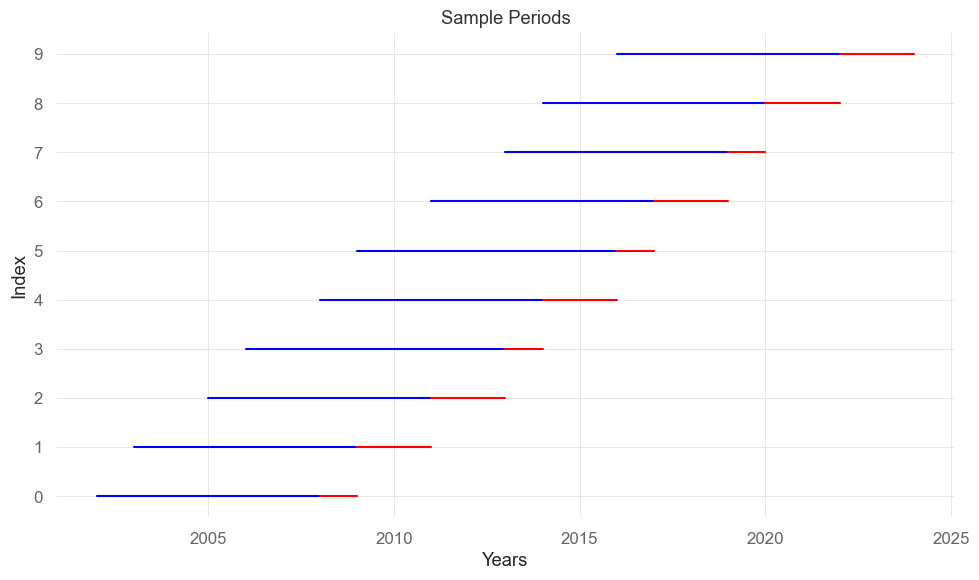

In [25]:
groups = 10
train = np.array(scaled_df[:])
X, y = train[:, :-1], train[:, -1]
calendar = build_rolling_calendar(start_date=scaled_df.index.min(), end_date=scaled_df.index.max(), out_of_sample_size=20, runs=10, n_gap=20)
# end_date=scaled_df.index.max()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in calendar.iterrows():
    ax.plot([row['InSampleStarts'].year, row['InSampleEnds'].year], [i, i], color='blue')
    ax.plot([row['OutSampleStarts'].year, row['OutSampleEnds'].year], [i, i], color='red')

# Customize plot
ax.set_yticks(calendar.index.values[::-1])
ax.set_yticklabels(calendar.index.values[::-1])
ax.set_xlabel('Years')
ax.set_ylabel('Index')
ax.set_title('Sample Periods')
ax.grid(True)

plt.tight_layout()
plt.show()

### TRAIN-TEST

In [26]:
X_train = []
X_valid = []
y_train = []
y_valid = []
for i, row in calendar.iterrows():
    train = scaled_df.loc[row['InSampleStarts']: row['InSampleEnds']].to_numpy()
    X_train.append(train[:, :-1])
    y_train.append(train[:, -1])
    valid = scaled_df.loc[row['OutSampleStarts']: row['OutSampleEnds']].to_numpy()
    X_valid.append(valid[:, :-1])
    y_valid.append(valid[:,-1])
    if i == 0: 
        X_train_signals = scaled_df.loc[row['OutSampleStarts']:].to_numpy()


flattened_y_valid = np.array(list(chain(*y_valid)))


### Feature Importance

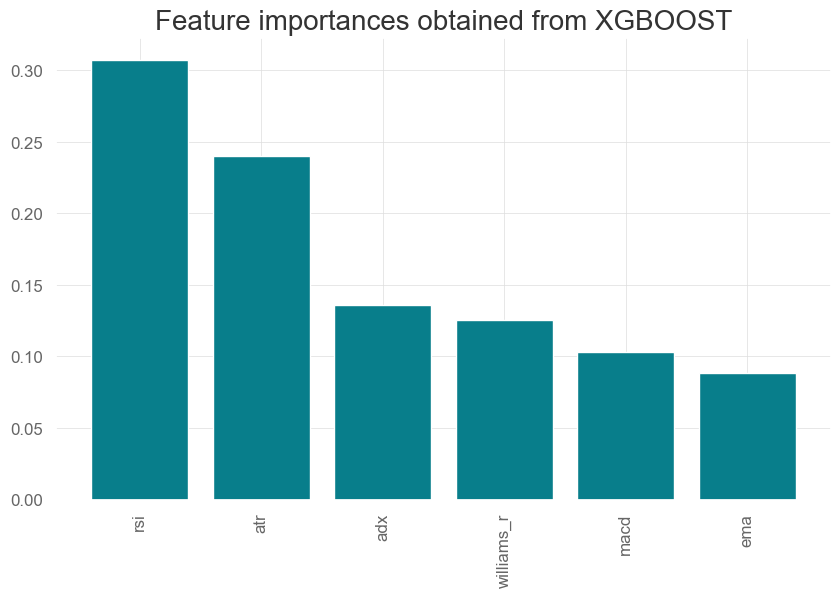

In [27]:
# Check first xgboost feature importance:
from xgboost import XGBRegressor

for i in range(len(X_train)):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train[i], y_train[i])
importances = pd.DataFrame(data={
    'Attribute': scaled_df.iloc[:, :-1].columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from XGBOOST', size=20)
plt.xticks(rotation='vertical')
plt.show()